# Download Files

In [ ]:
# import shutil
# from google.colab import files

# # Replace 'my_folder' with the name of your folder
# folder_name = 'models'

# # Create a zip file
# shutil.make_archive(folder_name, 'zip', folder_name)

# # Download the zip file
# files.download(f'{folder_name}.zip')

# Configuration

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
! unzip -o drive/MyDrive/dataset_19.zip

! pwd

Archive:  drive/MyDrive/dataset_19.zip
  inflating: dataset_19/glioma/Te-gl_0010.jpg  
  inflating: dataset_19/glioma/Te-gl_0016.jpg  
  inflating: dataset_19/glioma/Te-gl_0020.jpg  
  inflating: dataset_19/glioma/Te-gl_0026.jpg  
  inflating: dataset_19/glioma/Te-gl_0035.jpg  
  inflating: dataset_19/glioma/Te-gl_0041.jpg  
  inflating: dataset_19/glioma/Te-gl_0043.jpg  
  inflating: dataset_19/glioma/Te-gl_0044.jpg  
  inflating: dataset_19/glioma/Te-gl_0045.jpg  
  inflating: dataset_19/glioma/Te-gl_0057.jpg  
  inflating: dataset_19/glioma/Te-gl_0060.jpg  
  inflating: dataset_19/glioma/Te-gl_0075.jpg  
  inflating: dataset_19/glioma/Te-gl_0079.jpg  
  inflating: dataset_19/glioma/Te-gl_0085.jpg  
  inflating: dataset_19/glioma/Te-gl_0090.jpg  
  inflating: dataset_19/glioma/Te-gl_0107.jpg  
  inflating: dataset_19/glioma/Te-gl_0114.jpg  
  inflating: dataset_19/glioma/Te-gl_0125.jpg  
  inflating: dataset_19/glioma/Te-gl_0126.jpg  
  inflating: dataset_19/glioma/Te-gl_0127.jpg  
 

In [3]:
import os

import keras

print("Keras = {}".format(keras.__version__))
import tensorflow as tf

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
import seaborn as sns
import pandas as pd


# Print gpus
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))

MODEL_NAME_KERAS = "xception.keras"
MODEL_NAME_H5 = "xception.h5"
# MODEL_NAME_KERAS = "base_xception.keras"
# MODEL_NAME_H5 = "base_xception.h5"

BASE_MODEL_NAME_KERAS = "base_xception.keras"
BASE_MODEL_NAME_H5 = "base_xception.h5"

model_dir = './models/'
MODEL_FILE = model_dir + MODEL_NAME_KERAS
MODEL_FILE_H5 = model_dir + MODEL_NAME_H5

BASE_MODEL_FILE = model_dir + BASE_MODEL_NAME_KERAS
BASE_MODEL_FILE_H5 = model_dir + BASE_MODEL_NAME_H5

BATCH_SIZE = 10
# BATCH_SIZE = 12
TARGET_SIZE = (224,224)

Keras = 2.15.0
Num GPUs Available:  1


# Load Data

In [4]:
# Data Directories
dir = "dataset_19/"
validation_dir = "Testing"

## Data Distribution

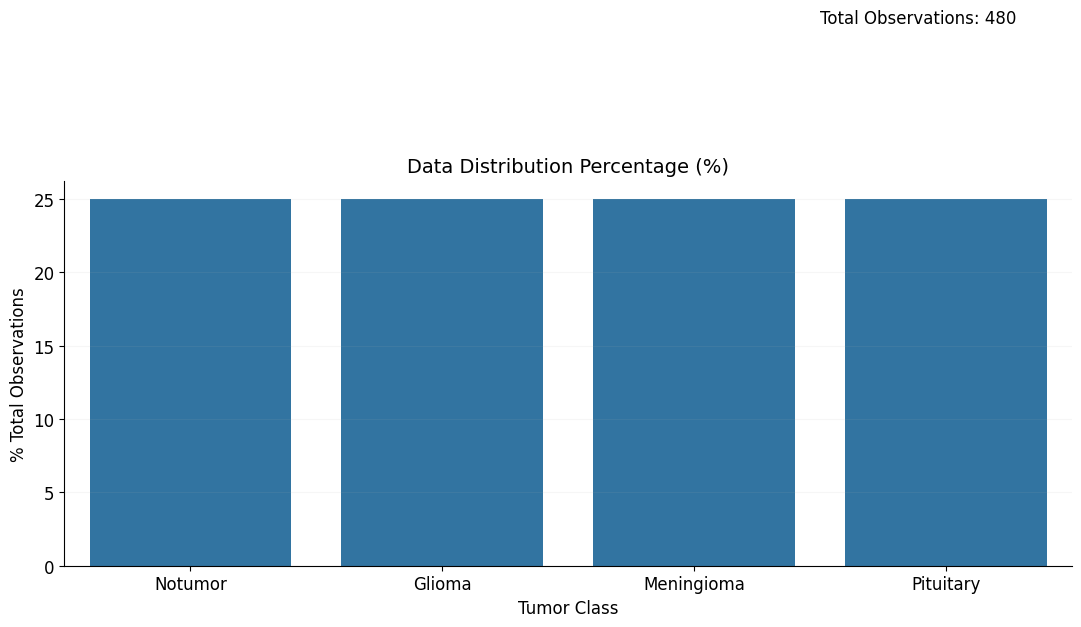

In [5]:
data_distribution_count = pd.Series(
    {curr_index: len(os.listdir(os.path.join(dir, curr_index))) for curr_index in os.listdir(dir)})

data_distribution_count

fig, axis = plt.subplots(figsize=(13, 5))
axis.grid(True, alpha=0.1)
axis.set_title("Data Distribution Percentage (%)", fontsize=14)
sns.barplot(x=['\n'.join(curr_index.strip().split('_')).title() for curr_index in data_distribution_count.index],
            y=100 * data_distribution_count / data_distribution_count.sum(), ax=axis)
axis.set_xlabel("Tumor Class", fontsize=12)
axis.set_ylabel("% Total Observations", fontsize=12)
axis.tick_params(which='major', labelsize=12)
axis.text(2.5, 37, f'Total Observations: {data_distribution_count.sum()}', fontdict=dict(size=12))
sns.despine()

# Preprocess Data

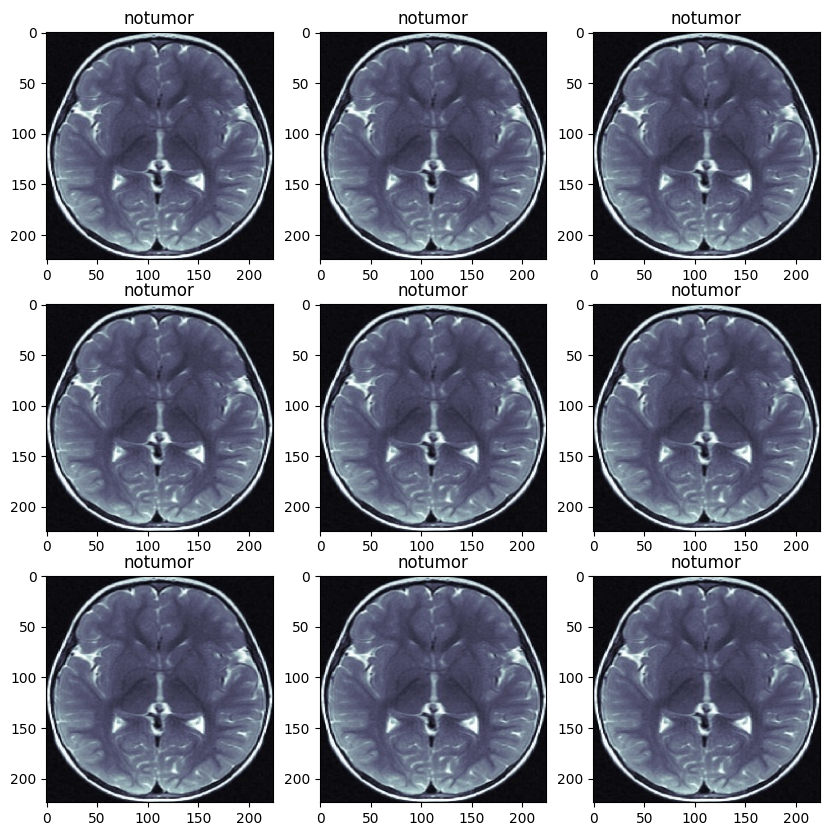

In [6]:
from tqdm import tqdm
import cv2
import imutils

def crop_img(img):

  # Find extreme points on the image and crop the rectangular out

  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  gray = cv2.GaussianBlur(gray, (3, 3), 0)

  # threshold the image, then perform a series of erosions +
  # dilations to remove any small regions of noise
  thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
  thresh = cv2.erode(thresh, None, iterations=2)
  thresh = cv2.dilate(thresh, None, iterations=2)

  # find contours in thresholded image, then grab the largest one
  cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  c = max(cnts, key=cv2.contourArea)

  # find the extreme points
  extLeft = tuple(c[c[:, :, 0].argmin()][0])
  extRight = tuple(c[c[:, :, 0].argmax()][0])
  extTop = tuple(c[c[:, :, 1].argmin()][0])
  extBot = tuple(c[c[:, :, 1].argmax()][0])
  ADD_PIXELS = 0
  new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

  return new_img

def preprocess_images(directory):
    for dir in os.listdir(directory):
        path = os.path.join(directory, dir)
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            img = cv2.imread(img_path)
            cropped_img = crop_img(img)
            processed_img = cv2.cvtColor(cropped_img, cv2.COLOR_RGB2GRAY)
            processed_img = cv2.bilateralFilter(processed_img, 2, 50, 50)
            processed_img = cv2.applyColorMap(processed_img, cv2.COLORMAP_BONE)
            processed_img = cv2.resize(processed_img, (224, 224))
            cv2.imwrite(img_path, processed_img)


# Preprocess the images before generating data
preprocess_images(dir)

# Display 9 image using matplotlib
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    for curr_index in os.listdir(dir):
        path = os.path.join(dir, curr_index)
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            image = plt.imread(img_path)
            plt.imshow(image)
            plt.title(curr_index)
            break
        break

# Splitting the data

In [7]:
classes = os.listdir(dir)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.05, # newly added
    height_shift_range=0.05, # newly added
    validation_split=0.2)

validation_datagen = ImageDataGenerator(
    rescale=1. / 255,
    validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    dir,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    seed=42,
    subset='training'
)

test_generator = validation_datagen.flow_from_directory(
    dir,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle = False,
    subset='validation')


print(test_generator.class_indices)

Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


# Create a Xception model

In [8]:
!pip install tensorflow-addons optuna

In [9]:
from tensorflow.keras.applications import Xception
from keras.utils import plot_model
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from keras.models import Model
from keras.regularizers import l2
from tensorflow_addons.optimizers import RectifiedAdam
# import sequential
from keras.models import Sequential
from keras.optimizers import Adam

# Initialize Xception pretrained model
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Exclude the bottom three layers (remove last 3 layers)
base_model_layers = base_model.layers[:-3]

# Create a new model with the remaining layers
x = base_model_layers[-1].output
x = GlobalAveragePooling2D()(x)
# x = Dropout(0.055)(x)
x = Dropout(0.32072197395702773)(x)

# Final dense layer with 4 neurons for classification
predictions = Dense(4, activation='softmax', kernel_regularizer=l2(0.1), dtype='float64')(x)

# Construct the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with RectifiedAdam optimizer
# optimizer = RectifiedAdam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
optimizer = RectifiedAdam(learning_rate=0.0006410837916333897, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 'categorical_accuracy'])



# # Initialize Xception pretrained model
# base_model = Xception(weights='imagenet', include_top=False, input_shape=(224,224,3))

# for layer in base_model.layers:
#   layer.trainable = False

# base_model.layers[-3].trainable = True
# base_model.layers[-2].trainable = True
# base_model.layers[-1].trainable = True

# # Add custom layers on top of the base model
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dropout(0.055)(x)
# predictions = Dense(4, activation='softmax', kernel_regularizer=l2(0.1), dtype='float64')(x)

# # Construct the final model
# model = Model(inputs=base_model.input, outputs=predictions)

# # optimizer = RectifiedAdam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
# optimizer = Adam(learning_rate=0.0001)

# model.compile(optimizer=optimizer,
#               loss='categorical_crossentropy',
#               metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 'categorical_accuracy'])

plot_model(model, to_file= 'xception_model.png', show_shapes=True, show_layer_names=True)

model.summary()

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 111, 111, 32)         0         ['block1_conv1_bn[0][0]'] 

# Train the model

In [10]:
from keras.callbacks import *

reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.3, min_lr=1e-6)
checkpoint = ModelCheckpoint(MODEL_FILE, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, mode='auto')

# Fit the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=150,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

# Save the model
model.save(MODEL_FILE)
model.save(MODEL_FILE_H5)

Epoch 1/150
38/38 [==============================] - ETA: 0s - loss: 2.1044 - accuracy: 0.4091 - precision: 1.0000 - recall: 0.0053 - categorical_accuracy: 0.4091
Epoch 1: val_loss improved from inf to 2.02799, saving model to ./models/xception.keras
38/38 [==============================] - 56s 329ms/step - loss: 2.1044 - accuracy: 0.4091 - precision: 1.0000 - recall: 0.0053 - categorical_accuracy: 0.4091 - val_loss: 2.0280 - val_accuracy: 0.5444 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_categorical_accuracy: 0.5444 - lr: 6.4108e-04
Epoch 2/150
38/38 [==============================] - ETA: 0s - loss: 1.5287 - accuracy: 0.7620 - precision: 0.9301 - recall: 0.4626 - categorical_accuracy: 0.7620
Epoch 2: val_loss improved from 2.02799 to 1.60761, saving model to ./models/xception.keras
38/38 [==============================] - 9s 236ms/step - loss: 1.5287 - accuracy: 0.7620 - precision: 0.9301 - recall: 0.4626 - categorical_accuracy: 0.7620 - val_loss: 1.6076 - val_accurac

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Testing the Model

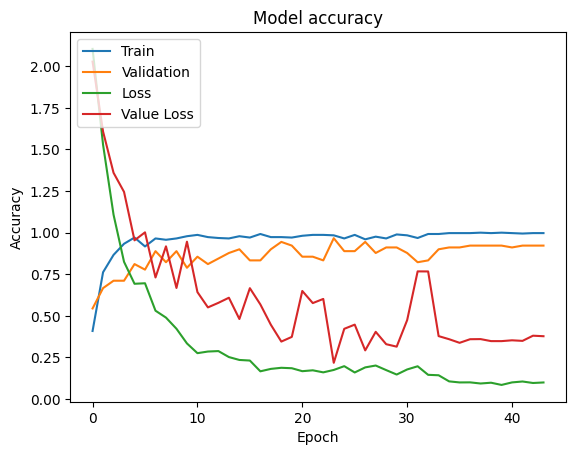

In [11]:
# Learning curve
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation','Loss', 'Value Loss'], loc='upper left')
plt.show()

In [12]:
# Validate the model with test data

model = keras.models.load_model(MODEL_FILE)
model.evaluate(test_generator)

# base_model = keras.models.load_model(BASE_MODEL_FILE)
# base_model_metrics = base_model.evaluate(test_generator)
# print(base_model_metrics)

# Predict and Display image using matplotlib
# plt.figure(figsize=(20, 20))
# for i in range(9):
#     plt.subplot(3, 3, i + 1)
#     for X_batch, Y_batch in test_generator:
#         image = X_batch[0]
#         # Print Class
#         plt.title("Predicted: " + classes[predictions[i]] + "\nActual: " + classes[np.argmax(Y_batch[i])])

#         plt.imshow(image)
#         break

10/10 [==============================] - 6s 311ms/step - loss: 0.3670 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - categorical_accuracy: 0.9271


[0.3669552505016327,
 0.9270833134651184,
 0.9270833134651184,
 0.9270833134651184,
 0.9270833134651184]

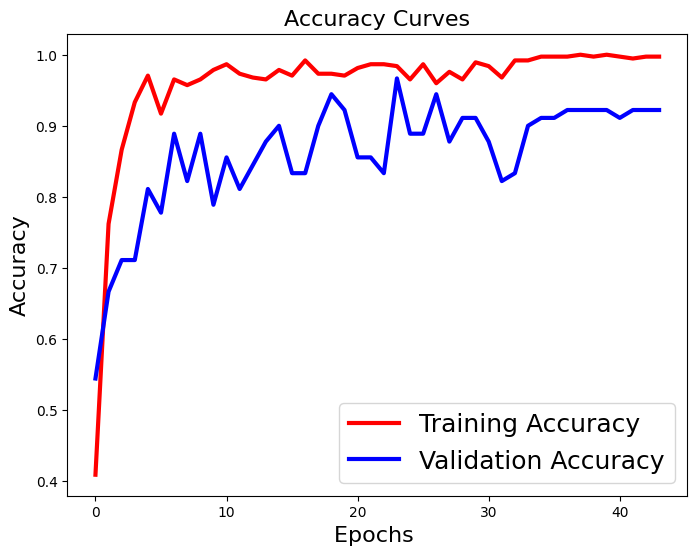

In [13]:
#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)
plt.show()

# Model Visualisation (Evaluation)

10/10 [==============================] - 2s 60ms/step


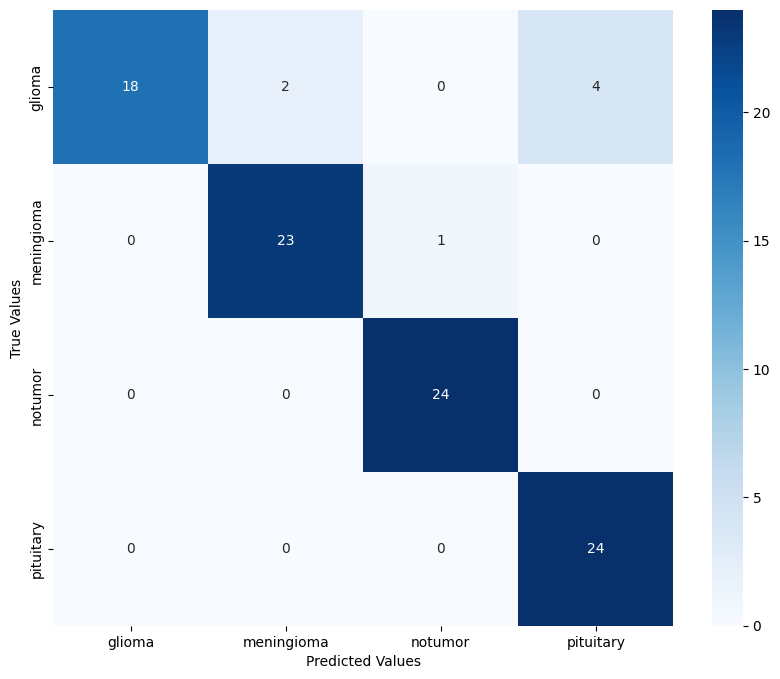

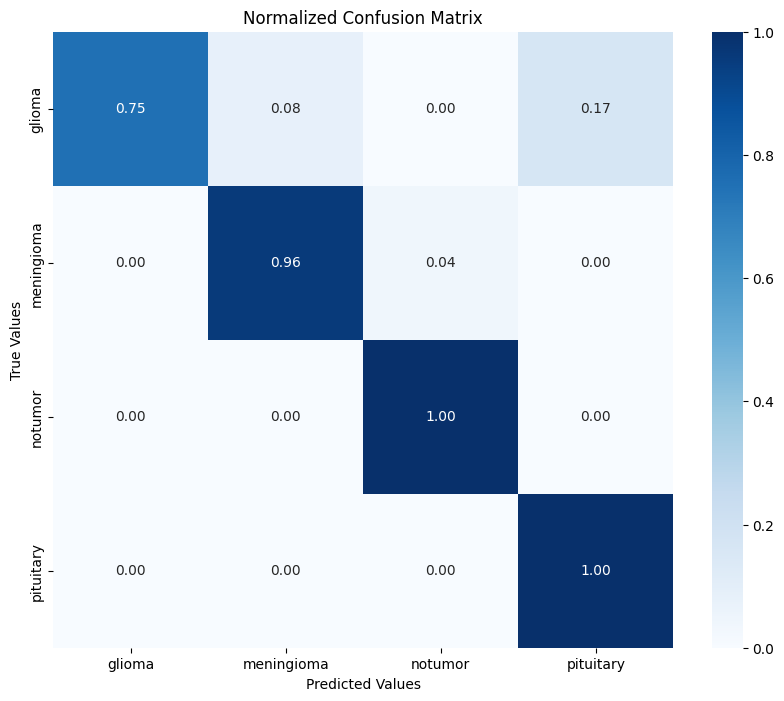

DSC: 0.9246467817896389, Sensitivity: 0.9270833333333334, Specificity: 0.9756944444444444, Accuracy: 0.9270833333333334


In [14]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

def calculate_metrics(y_true, y_pred):
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Values')
    plt.ylabel('True Values')
    plt.show()

    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot the normalized confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Values')
    plt.ylabel('True Values')
    plt.title('Normalized Confusion Matrix')
    plt.show()

    # Calculate metrics for each class and average them
    dsc = np.mean([2.0 * cm[i, i] / (np.sum(cm[i, :]) + np.sum(cm[:, i])) for i in range(cm.shape[0])])
    sensitivity = np.mean([cm[i, i] / np.sum(cm[i, :]) for i in range(cm.shape[0])])
    specificity = np.mean([np.sum(np.delete(np.delete(cm, j, 0), j, 1)) / np.sum(np.delete(cm, j, 0)) for j in range(cm.shape[0])])

    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)

    return dsc, sensitivity, specificity, accuracy

# Predict the output
predictions_prob = model.predict(test_generator)
predictions = np.argmax(predictions_prob, axis=1)

dsc, sensitivity, specificity, accuracy = calculate_metrics(test_generator.classes, predictions)
print(f"DSC: {dsc}, Sensitivity: {sensitivity}, Specificity: {specificity}, Accuracy: {accuracy}")

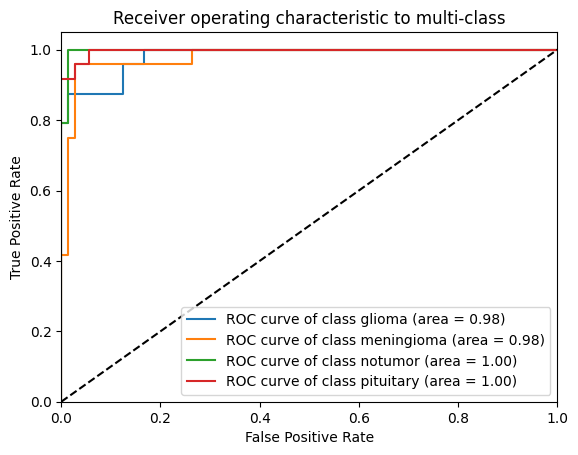

              precision    recall  f1-score   support

      glioma       1.00      0.75      0.86        24
  meningioma       0.92      0.96      0.94        24
     notumor       0.96      1.00      0.98        24
   pituitary       0.86      1.00      0.92        24

   micro avg       0.93      0.93      0.93        96
   macro avg       0.93      0.93      0.92        96
weighted avg       0.93      0.93      0.92        96
 samples avg       0.93      0.93      0.93        96



In [15]:
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import numpy as np

# Binarize the output
lb = LabelBinarizer()
y_test = lb.fit_transform(test_generator.classes)
y_pred = lb.transform(predictions)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], predictions_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i, class_name in enumerate(classes):
    plt.plot(fpr[i], tpr[i],
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_name, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# Print classification report
print(classification_report(y_test, y_pred, target_names=classes))

# K-Folds Validation

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from tensorflow_addons.optimizers import RectifiedAdam
from keras.applications import Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.regularizers import l2
from keras.models import Model

# Set parameters
dir = 'dataset_19'  # Update this to your dataset directory
batch_size = 10
input_shape = (224, 224, 3)
num_classes = 4
initial_learning_rate = 1e-4
k = 5

# Prepare data generators
datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.05,
    height_shift_range=0.05)

# List all images and labels
all_images = []
all_labels = []

for class_index, class_name in enumerate(os.listdir(dir)):
    class_dir = os.path.join(dir, class_name)
    for image_name in os.listdir(class_dir):
        all_images.append(os.path.join(class_dir, image_name))
        all_labels.append(str(class_index))  # Convert class index to string

# Convert lists to numpy arrays
all_images = np.array(all_images)
all_labels = np.array(all_labels)

# Define K-Fold cross-validation
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Initialize lists to store metrics
fold_accuracies = []
fold_losses = []

# Iterate over each fold
for fold, (train_index, val_index) in enumerate(kf.split(all_images)):
    print(f'Fold {fold + 1}/{k}')

    train_images, val_images = all_images[train_index], all_images[val_index]
    train_labels, val_labels = all_labels[train_index], all_labels[val_index]

    # Create DataFrames for training and validation data
    train_df = pd.DataFrame({'filename': train_images, 'class': train_labels})
    val_df = pd.DataFrame({'filename': val_images, 'class': val_labels})

    # Create training and validation data generators
    train_generator = datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='filename',
        y_col='class',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    validation_generator = datagen.flow_from_dataframe(
        dataframe=val_df,
        x_col='filename',
        y_col='class',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    # Load the Xception model, include the top layers
    base_model = Xception(weights='imagenet', include_top=False,input_shape=(224,224,3))

    # Exclude the bottom three layers (remove last 3 layers)
    base_model_layers = base_model.layers[:-3]

    # Create a new model with the remaining layers
    x = base_model_layers[-1].output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.32072197395702773)(x)

    # Final dense layer with 4 neurons for classification
    predictions = Dense(4, activation='softmax', kernel_regularizer=l2(0.1), dtype='float64')(x)

    # Construct the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model with RectifiedAdam optimizer
    optimizer = RectifiedAdam(learning_rate=0.0006410837916333897, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 'categorical_accuracy'])


    # Callbacks
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.3, min_lr=1e-6, verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='auto')

    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=90,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // validation_generator.batch_size,
        callbacks=[early_stopping, reduce_lr]
    )

    # Store the best validation accuracy and loss for the current fold
    best_val_accuracy = max(history.history['val_accuracy'])
    best_val_loss = min(history.history['val_loss'])
    fold_accuracies.append(best_val_accuracy)
    fold_losses.append(best_val_loss)

# Calculate mean and standard deviation of accuracies and losses
mean_accuracy = np.mean(fold_accuracies)
std_accuracy = np.std(fold_accuracies)
mean_loss = np.mean(fold_losses)
std_loss = np.std(fold_losses)

print(f'Validation Accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}')
print(f'Validation Loss: {mean_loss:.4f} ± {std_loss:.4f}')

Fold 1/5
Found 384 validated image filenames belonging to 4 classes.
Found 96 validated image filenames belonging to 4 classes.
87910968/87910968 [==============================] - 5s 0us/step
Epoch 1/90
38/38 [==============================] - 30s 235ms/step - loss: 2.1249 - accuracy: 0.3658 - precision_1: 0.5333 - recall_1: 0.0632 - categorical_accuracy: 0.3658 - val_loss: 2.0254 - val_accuracy: 0.4778 - val_precision_1: 0.5510 - val_recall_1: 0.3000 - val_categorical_accuracy: 0.4778 - lr: 6.4108e-04
Epoch 2/90
38/38 [==============================] - 11s 297ms/step - loss: 1.6144 - accuracy: 0.6952 - precision_1: 0.8475 - recall_1: 0.5053 - categorical_accuracy: 0.6952 - val_loss: 1.8121 - val_accuracy: 0.6889 - val_precision_1: 0.7468 - val_recall_1: 0.6556 - val_categorical_accuracy: 0.6889 - lr: 6.4108e-04
Epoch 3/90
38/38 [==============================] - 9s 227ms/step - loss: 1.1857 - accuracy: 0.8529 - precision_1: 0.8952 - recall_1: 0.7995 - categorical_accuracy: 0.8529 - v

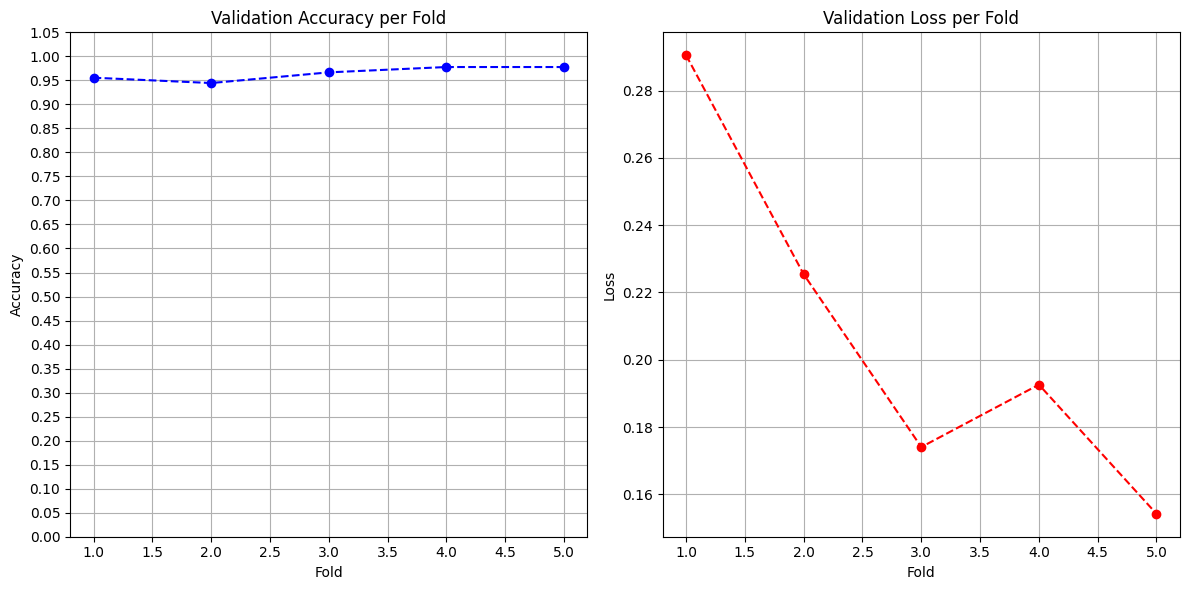

In [ ]:
import matplotlib.pyplot as plt

# Plot validation accuracies
plt.figure(figsize=(12, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(range(1, k + 1), fold_accuracies, marker='o', linestyle='--', color='b')
plt.title('Validation Accuracy per Fold')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.yticks(np.arange(0, 1.1, 0.05))
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(range(1, k + 1), fold_losses, marker='o', linestyle='--', color='r')
plt.title('Validation Loss per Fold')
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.grid(True)

# Show plots
plt.tight_layout()
plt.show()

# Optuna

In [ ]:
import os
import optuna
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications import Xception
from keras.utils import plot_model
from keras.regularizers import l2
from tensorflow_addons.optimizers import RectifiedAdam

classes = os.listdir(dir)

# Data generator setup
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.05, # newly added
    height_shift_range=0.05, # newly added
    validation_split=0.2)

validation_datagen = ImageDataGenerator(rescale=1. / 255, validation_split=0.2)

# Model creation function modified for Optuna
def create_model(input_shape, num_classes, trial):
    # Suggest hyperparameters
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.05, 0.5)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)

    base_model = Xception(weights='imagenet', include_top=False, input_shape=(224,224,3))
    base_model_layers = base_model.layers[:-3]

    x = base_model_layers[-1].output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)

    predictions = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.1), dtype='float64')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    optimizer = RectifiedAdam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 'categorical_accuracy'])

    return model

# Objective function for Optuna
def objective(trial):
    # Get suggested batch size
    batch_size = 10

    train_generator = train_datagen.flow_from_directory(
        dir,
        target_size=(224, 224),
        batch_size=batch_size,
        seed=42,
        subset='training'
    )

    test_generator = validation_datagen.flow_from_directory(
        dir,
        target_size=(224, 224),
        batch_size=batch_size,
        seed=42,
        subset='validation'
    )

    model = create_model((224, 224, 3), len(classes), trial)
    checkpoint = ModelCheckpoint(MODEL_FILE, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)

    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        validation_data=test_generator,
        validation_steps=test_generator.samples // test_generator.batch_size,
        epochs=100,
        callbacks=[checkpoint, early_stopping]
    )

    # Load the best weights before returning the final validation loss
    model.load_weights(MODEL_FILE)

    # Store the training history in the trial
    trial.set_user_attr('history', history.history)

    # Evaluate the model with the best weights on the validation set
    val_loss = model.evaluate(test_generator, steps=test_generator.samples // batch_size, verbose=0)[0]

    return val_loss

# Run Optuna optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# Best trial results
print('Best trial:')
trial = study.best_trial
print(f'  Value: {trial.value}')
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

history = trial.user_attrs['history']


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
[I 2024-06-11 12:30:50,821] A new study created in memory with name: no-name-c942551f-9708-478b-ae92-c40e327236e6


Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.


<ipython-input-11-e9b18c1c07ef>:30: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.05, 0.5)
<ipython-input-11-e9b18c1c07ef>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


83683744/83683744 [==============================] - 1s 0us/step
Epoch 1/100
38/38 [==============================] - ETA: 0s - loss: 2.1793 - accuracy: 0.2513 - precision: 0.0000e+00 - recall: 0.0000e+00 - categorical_accuracy: 0.2513
Epoch 1: val_loss improved from inf to 2.17365, saving model to ./models/xception.keras
38/38 [==============================] - 52s 305ms/step - loss: 2.1793 - accuracy: 0.2513 - precision: 0.0000e+00 - recall: 0.0000e+00 - categorical_accuracy: 0.2513 - val_loss: 2.1737 - val_accuracy: 0.2333 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_categorical_accuracy: 0.2333
Epoch 2/100
38/38 [==============================] - ETA: 0s - loss: 2.0989 - accuracy: 0.2941 - precision: 1.0000 - recall: 0.0080 - categorical_accuracy: 0.2941
Epoch 2: val_loss improved from 2.17365 to 2.13212, saving model to ./models/xception.keras
38/38 [==============================] - 9s 246ms/step - loss: 2.0989 - accuracy: 0.2941 - precision: 1.0000 - recall: 0.0080

[I 2024-06-11 12:43:36,750] Trial 0 finished with value: 0.34919384121894836 and parameters: {'dropout_rate': 0.08547580358651458, 'learning_rate': 7.296314590805521e-05}. Best is trial 0 with value: 0.34919384121894836.


Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
Epoch 1/100
38/38 [==============================] - ETA: 0s - loss: 2.1794 - accuracy: 0.1979 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - categorical_accuracy: 0.1979
Epoch 1: val_loss improved from inf to 2.18623, saving model to ./models/xception.keras
38/38 [==============================] - 22s 275ms/step - loss: 2.1794 - accuracy: 0.1979 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - categorical_accuracy: 0.1979 - val_loss: 2.1862 - val_accuracy: 0.2333 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_categorical_accuracy: 0.2333
Epoch 2/100
38/38 [==============================] - ETA: 0s - loss: 2.1536 - accuracy: 0.2727 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - categorical_accuracy: 0.2727
Epoch 2: val_loss improved from 2.18623 to 2.15648, saving model to ./models/xception.keras
38/38 [==============================] - 9s 225ms/step - loss: 2.1536 - accuracy: 0.2

[I 2024-06-11 12:57:31,671] Trial 1 finished with value: 0.534247100353241 and parameters: {'dropout_rate': 0.38298647564055044, 'learning_rate': 4.385872460324822e-05}. Best is trial 0 with value: 0.34919384121894836.


Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
Epoch 1/100
38/38 [==============================] - ETA: 0s - loss: 2.2049 - accuracy: 0.2246 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - categorical_accuracy: 0.2246
Epoch 1: val_loss improved from inf to 2.19306, saving model to ./models/xception.keras
38/38 [==============================] - 22s 272ms/step - loss: 2.2049 - accuracy: 0.2246 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - categorical_accuracy: 0.2246 - val_loss: 2.1931 - val_accuracy: 0.2444 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_categorical_accuracy: 0.2444
Epoch 2/100
38/38 [==============================] - ETA: 0s - loss: 2.1805 - accuracy: 0.2763 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - categorical_accuracy: 0.2763
Epoch 2: val_loss improved from 2.19306 to 2.17774, saving model to ./models/xception.keras
38/38 [==============================] - 8s 218ms/step - loss: 2.1805 - accuracy: 0.2

[I 2024-06-11 13:12:40,371] Trial 2 finished with value: 0.5036858320236206 and parameters: {'dropout_rate': 0.1427256595003939, 'learning_rate': 2.0184063389177823e-05}. Best is trial 0 with value: 0.34919384121894836.


Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
Epoch 1/100
38/38 [==============================] - ETA: 0s - loss: 2.1960 - accuracy: 0.2005 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - categorical_accuracy: 0.2005
Epoch 1: val_loss improved from inf to 2.17191, saving model to ./models/xception.keras
38/38 [==============================] - 22s 263ms/step - loss: 2.1960 - accuracy: 0.2005 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - categorical_accuracy: 0.2005 - val_loss: 2.1719 - val_accuracy: 0.2889 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_categorical_accuracy: 0.2889
Epoch 2/100
38/38 [==============================] - ETA: 0s - loss: 2.1556 - accuracy: 0.2861 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - categorical_accuracy: 0.2861
Epoch 2: val_loss improved from 2.17191 to 2.13407, saving model to ./models/xception.keras
38/38 [==============================] - 8s 209ms/step - loss: 2.1556 - accuracy: 0.2

[I 2024-06-11 13:28:00,710] Trial 3 finished with value: 0.35611072182655334 and parameters: {'dropout_rate': 0.3866171909568328, 'learning_rate': 4.0005694077745846e-05}. Best is trial 0 with value: 0.34919384121894836.


Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
Epoch 1/100
38/38 [==============================] - ETA: 0s - loss: 2.1722 - accuracy: 0.2727 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - categorical_accuracy: 0.2727
Epoch 1: val_loss improved from inf to 2.16683, saving model to ./models/xception.keras
38/38 [==============================] - 21s 267ms/step - loss: 2.1722 - accuracy: 0.2727 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - categorical_accuracy: 0.2727 - val_loss: 2.1668 - val_accuracy: 0.3333 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_categorical_accuracy: 0.3333
Epoch 2/100
38/38 [==============================] - ETA: 0s - loss: 2.1667 - accuracy: 0.2941 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - categorical_accuracy: 0.2941
Epoch 2: val_loss improved from 2.16683 to 2.16352, saving model to ./models/xception.keras
38/38 [==============================] - 8s 204ms/step - loss: 2.1667 - accuracy: 0.2

[I 2024-06-11 13:43:18,145] Trial 4 finished with value: 0.8409423232078552 and parameters: {'dropout_rate': 0.35544642613684885, 'learning_rate': 1.1852895640290898e-05}. Best is trial 0 with value: 0.34919384121894836.


Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
Epoch 1/100
38/38 [==============================] - ETA: 0s - loss: 2.2027 - accuracy: 0.2513 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - categorical_accuracy: 0.2513
Epoch 1: val_loss improved from inf to 2.15638, saving model to ./models/xception.keras
38/38 [==============================] - 21s 252ms/step - loss: 2.2027 - accuracy: 0.2513 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - categorical_accuracy: 0.2513 - val_loss: 2.1564 - val_accuracy: 0.4333 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_categorical_accuracy: 0.4333
Epoch 2/100
38/38 [==============================] - ETA: 0s - loss: 2.1401 - accuracy: 0.4011 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - categorical_accuracy: 0.4011
Epoch 2: val_loss improved from 2.15638 to 2.12582, saving model to ./models/xception.keras
38/38 [==============================] - 9s 241ms/step - loss: 2.1401 - accuracy: 0.4

[I 2024-06-11 13:58:41,867] Trial 5 finished with value: 0.29378658533096313 and parameters: {'dropout_rate': 0.14351216367810643, 'learning_rate': 4.9941243461779974e-05}. Best is trial 5 with value: 0.29378658533096313.


Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
Epoch 1/100
38/38 [==============================] - ETA: 0s - loss: 2.1819 - accuracy: 0.3182 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - categorical_accuracy: 0.3182
Epoch 1: val_loss improved from inf to 2.16732, saving model to ./models/xception.keras
38/38 [==============================] - 22s 255ms/step - loss: 2.1819 - accuracy: 0.3182 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - categorical_accuracy: 0.3182 - val_loss: 2.1673 - val_accuracy: 0.3000 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00 - val_categorical_accuracy: 0.3000
Epoch 2/100
38/38 [==============================] - ETA: 0s - loss: 2.1275 - accuracy: 0.4278 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - categorical_accuracy: 0.4278
Epoch 2: val_loss improved from 2.16732 to 2.12250, saving model to ./models/xception.keras
38/38 [==============================] - 8s 206ms/step - loss: 2.1275 - accuracy: 0.4

[I 2024-06-11 14:09:55,953] Trial 6 finished with value: 0.3859175741672516 and parameters: {'dropout_rate': 0.2841213120434645, 'learning_rate': 6.310132295151657e-05}. Best is trial 5 with value: 0.29378658533096313.


Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
Epoch 1/100
38/38 [==============================] - ETA: 0s - loss: 2.1643 - accuracy: 0.3368 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00 - categorical_accuracy: 0.3368
Epoch 1: val_loss improved from inf to 2.13856, saving model to ./models/xception.keras
38/38 [==============================] - 21s 235ms/step - loss: 2.1643 - accuracy: 0.3368 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00 - categorical_accuracy: 0.3368 - val_loss: 2.1386 - val_accuracy: 0.4333 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00 - val_categorical_accuracy: 0.4333
Epoch 2/100
38/38 [==============================] - ETA: 0s - loss: 1.7478 - accuracy: 0.7567 - precision_7: 0.9146 - recall_7: 0.2005 - categorical_accuracy: 0.7567
Epoch 2: val_loss improved from 2.13856 to 1.86803, saving model to ./models/xception.keras
38/38 [==============================] - 10s 253ms/step - loss: 1.7478 - accuracy: 0.7567 - p

[I 2024-06-11 14:17:33,709] Trial 7 finished with value: 0.38123419880867004 and parameters: {'dropout_rate': 0.19051209584185103, 'learning_rate': 0.00037456376338867065}. Best is trial 5 with value: 0.29378658533096313.


Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
Epoch 1/100
38/38 [==============================] - ETA: 0s - loss: 2.1906 - accuracy: 0.2406 - precision_8: 0.0000e+00 - recall_8: 0.0000e+00 - categorical_accuracy: 0.2406
Epoch 1: val_loss improved from inf to 2.17733, saving model to ./models/xception.keras
38/38 [==============================] - 21s 237ms/step - loss: 2.1906 - accuracy: 0.2406 - precision_8: 0.0000e+00 - recall_8: 0.0000e+00 - categorical_accuracy: 0.2406 - val_loss: 2.1773 - val_accuracy: 0.2444 - val_precision_8: 0.0000e+00 - val_recall_8: 0.0000e+00 - val_categorical_accuracy: 0.2444
Epoch 2/100
38/38 [==============================] - ETA: 0s - loss: 2.1548 - accuracy: 0.2834 - precision_8: 0.0000e+00 - recall_8: 0.0000e+00 - categorical_accuracy: 0.2834
Epoch 2: val_loss improved from 2.17733 to 2.17040, saving model to ./models/xception.keras
38/38 [==============================] - 9s 224ms/step - loss: 2.1548 - accuracy: 0.2

[I 2024-06-11 14:33:18,734] Trial 8 finished with value: 0.7407090067863464 and parameters: {'dropout_rate': 0.3319618703141043, 'learning_rate': 2.1887561464853183e-05}. Best is trial 5 with value: 0.29378658533096313.


Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
Epoch 1/100
38/38 [==============================] - ETA: 0s - loss: 2.0711 - accuracy: 0.4251 - precision_9: 1.0000 - recall_9: 0.0160 - categorical_accuracy: 0.4251
Epoch 1: val_loss improved from inf to 2.05145, saving model to ./models/xception.keras
38/38 [==============================] - 21s 268ms/step - loss: 2.0711 - accuracy: 0.4251 - precision_9: 1.0000 - recall_9: 0.0160 - categorical_accuracy: 0.4251 - val_loss: 2.0514 - val_accuracy: 0.4778 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00 - val_categorical_accuracy: 0.4778
Epoch 2/100
38/38 [==============================] - ETA: 0s - loss: 1.4853 - accuracy: 0.7914 - precision_9: 0.9010 - recall_9: 0.4866 - categorical_accuracy: 0.7914
Epoch 2: val_loss improved from 2.05145 to 1.68996, saving model to ./models/xception.keras
38/38 [==============================] - 8s 209ms/step - loss: 1.4853 - accuracy: 0.7914 - precision_9: 0.901

[I 2024-06-11 14:40:03,101] Trial 9 finished with value: 0.27604877948760986 and parameters: {'dropout_rate': 0.32072197395702773, 'learning_rate': 0.0006410837916333897}. Best is trial 9 with value: 0.27604877948760986.


Best trial:
  Value: 0.27604877948760986
  Params: 
    dropout_rate: 0.32072197395702773
    learning_rate: 0.0006410837916333897
